In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

import matplotlib.pyplot as plt


In [2]:
# Get the USPS dataset
batch_size = 128

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.EuroSAT(root='./data', download=False, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

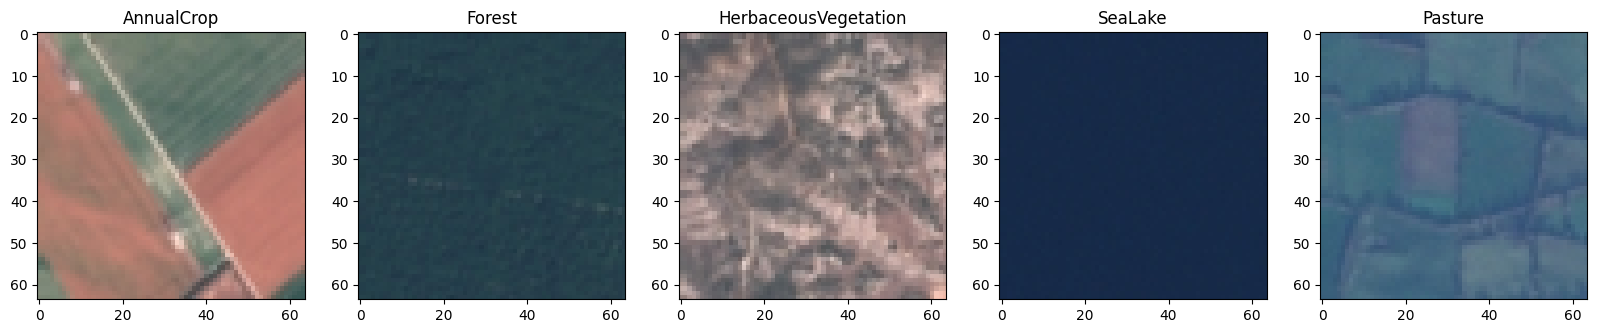

In [3]:
def show_image(dataset, index):
    image, label = dataset[index]
    image = image / 2 + 0.5
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title(classes[label])

plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    show_image(train_dataset, i * 100)
plt.show()

In [4]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.flattend_size = 32 * 4 * 4
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(16, 32, 7, padding=3)
        self.fc1 = nn.Linear(self.flattend_size, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        self.batch_norm = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch_norm(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm2(x)
        x = x.view(-1, self.flattend_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
def train(net, trainloader, optimizer, loss):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss_val = loss(outputs, labels)
        loss_val.backward()
        optimizer.step()
        running_loss += loss_val.item()

        if i % 5 == 0:
            print(f"[{i + 1}, {len(trainloader)}] loss: {running_loss / 100}")
            running_loss = 0.0

    return running_loss / len(trainloader)

def test(net, testloader, loss):
    net.eval()
    running_loss = 0.0
    correct      = 0
    total        = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss_val = loss(outputs, labels)
            running_loss += loss_val.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def training_loop(epochs, net, trainloader, testloader, optimizer, loss):
    accuracies = []
    losses = []


    start_time = time.time()
    for epoch in range(epochs):
        train_loss = train(net, trainloader, optimizer, loss)
        accuracy = test(net, testloader, loss)
        accuracies.append(accuracy)
        losses.append(train_loss)
        print(f"Epoch {epoch} - Train Loss: {train_loss} Accuracy: {accuracy}")

    end_time = time.time()

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(accuracies)
    plt.title('Accuracy')
    plt.xlabel('Epoch [#]')
    plt.ylabel('Accuracy [%]')
    plt.subplot(122)
    plt.plot(losses)
    plt.title('Loss')
    plt.xlabel('Epoch [#]')
    plt.ylabel('Loss [NLL]')
    plt.show()

    return accuracies, losses, end_time - start_time

In [7]:
net = CustomCNN()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()
net.to(device)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_20.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package


[1, 169] loss: 0.023050715923309328
[6, 169] loss: 0.11536665439605713
[11, 169] loss: 0.11261368751525878
[16, 169] loss: 0.11138566017150879
[21, 169] loss: 0.11017875671386719
[26, 169] loss: 0.10733222484588623
[31, 169] loss: 0.10635108947753906
[36, 169] loss: 0.10460056781768799
[41, 169] loss: 0.10401584148406982
[46, 169] loss: 0.10225090265274048
[51, 169] loss: 0.1007752239704132
[56, 169] loss: 0.09867568254470825
[61, 169] loss: 0.0980226767063141
[66, 169] loss: 0.09587310314178467
[71, 169] loss: 0.09253829956054688
[76, 169] loss: 0.09152684569358825
[81, 169] loss: 0.08945270538330079
[86, 169] loss: 0.08703425884246827
[91, 169] loss: 0.08526082634925843
[96, 169] loss: 0.08494210362434387
[101, 169] loss: 0.08364990949630738
[106, 169] loss: 0.081156405210495
[111, 169] loss: 0.07952707529067993
[116, 169] loss: 0.08011257767677307
[121, 169] loss: 0.07769396901130676
[126, 169] loss: 0.07936792612075806
[131, 169] loss: 0.07577521204948426
[136, 169] loss: 0.0750377

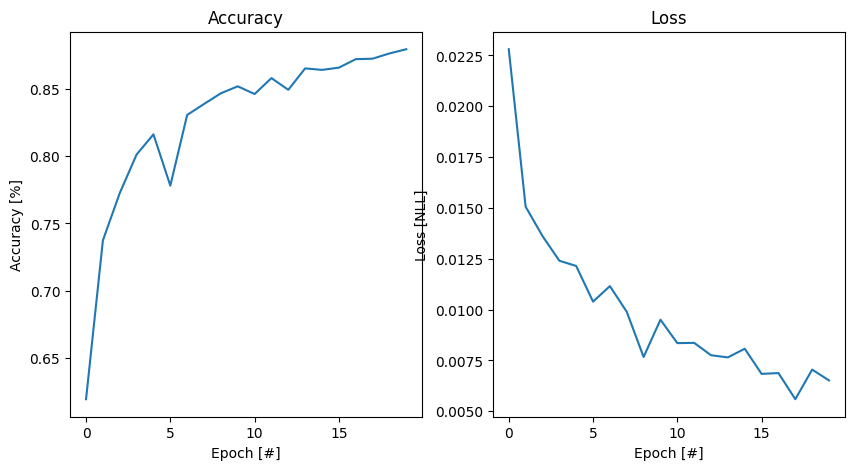

Best accuracy: 0.8796296296296297


In [8]:
EPOCHS = 20

accuracies_custom, losses_custom, time_custom = training_loop(EPOCHS, net, trainloader, testloader, optimizer, loss)

print(f"Best accuracy: {max(accuracies_custom)}")

Training last resnet layer
[1, 169] loss: 0.025887176990509034
[6, 169] loss: 0.11396784782409668
[11, 169] loss: 0.10281064629554748
[16, 169] loss: 0.08740336894989013
[21, 169] loss: 0.07712820649147034
[26, 169] loss: 0.07327332854270935
[31, 169] loss: 0.06387521147727966
[36, 169] loss: 0.05839893817901611
[41, 169] loss: 0.053687020540237426
[46, 169] loss: 0.05104213416576386
[51, 169] loss: 0.04929133713245392
[56, 169] loss: 0.0466016560792923
[61, 169] loss: 0.04276754140853882
[66, 169] loss: 0.04322379767894745
[71, 169] loss: 0.04344064235687256
[76, 169] loss: 0.041125608682632445
[81, 169] loss: 0.03898833215236664
[86, 169] loss: 0.04135730385780335
[91, 169] loss: 0.03691474020481109
[96, 169] loss: 0.037936472296714784
[101, 169] loss: 0.03540245175361633
[106, 169] loss: 0.03375227212905884
[111, 169] loss: 0.03740926206111908
[116, 169] loss: 0.03467475473880768
[121, 169] loss: 0.03139481544494629
[126, 169] loss: 0.030702253580093385
[131, 169] loss: 0.0335745894

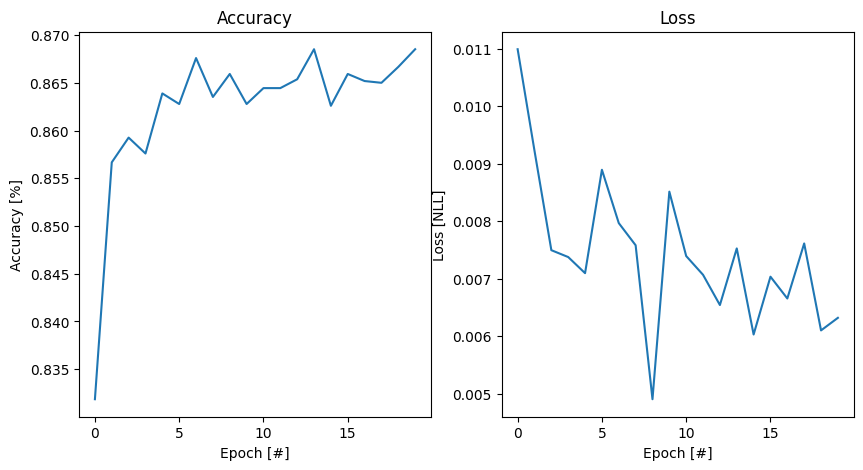

Best accuracy: 0.8685185185185185


In [9]:
resnet_fc = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze all layers except the last one
for name, param in resnet_fc.named_parameters():
    param.requires_grad = False

resnet_fc.fc = nn.Linear(512, 10)

resnet_fc.to(device)

# Train the last layer
optimizer = optim.Adam(resnet_fc.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
resnet_fc.to(device)

print("Training last resnet layer")

accuracies_resnet_fc, losses_resnet_fc, time_resnet_fc = training_loop(EPOCHS, resnet_fc, trainloader, testloader, optimizer, loss)

print(f"Best accuracy: {max(accuracies_resnet_fc)}")

Fine tuning resnet
[1, 169] loss: 0.027001466751098633
[6, 169] loss: 0.09554677367210389
[11, 169] loss: 0.05941484272480011
[16, 169] loss: 0.04107835590839386
[21, 169] loss: 0.02815030366182327
[26, 169] loss: 0.02189501702785492
[31, 169] loss: 0.019274044930934906
[36, 169] loss: 0.01787507623434067
[41, 169] loss: 0.014998474270105361
[46, 169] loss: 0.011936842352151871
[51, 169] loss: 0.016011572778224945
[56, 169] loss: 0.011272449344396591
[61, 169] loss: 0.01034443885087967
[66, 169] loss: 0.009831465035676955
[71, 169] loss: 0.011788655370473862
[76, 169] loss: 0.008541110157966613
[81, 169] loss: 0.01025223895907402
[86, 169] loss: 0.009474708437919617
[91, 169] loss: 0.00903244324028492
[96, 169] loss: 0.011271364539861679
[101, 169] loss: 0.008978860080242157
[106, 169] loss: 0.006945190727710724
[111, 169] loss: 0.010392467826604843
[116, 169] loss: 0.008549659326672555
[121, 169] loss: 0.008153355419635773
[126, 169] loss: 0.007928197532892227
[131, 169] loss: 0.00733

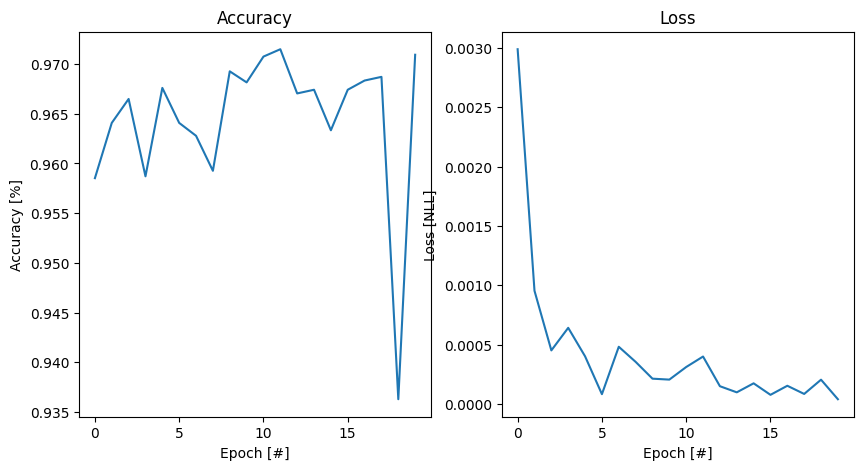

Best accuracy: 0.9714814814814815


In [10]:
resnet_finetuned    = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet_finetuned.fc = nn.Linear(512, 10)

resnet_finetuned.to(device)

# Train the last layer
optimizer = optim.Adam(resnet_finetuned.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()
resnet_finetuned.to(device)

print("Fine tuning resnet")
accuracies_resnet_ft, losses_resnet_ft, time_resnet_ft = training_loop(EPOCHS, resnet_finetuned, trainloader, testloader, optimizer, loss)

print(f"Best accuracy: {max(accuracies_resnet_ft)}")

Training last effnet layer
[1, 169] loss: 0.023530192375183105
[6, 169] loss: 0.11014973878860473
[11, 169] loss: 0.10115020871162414
[16, 169] loss: 0.09533749580383301
[21, 169] loss: 0.08886203050613403
[26, 169] loss: 0.08309551954269409
[31, 169] loss: 0.08062646746635437
[36, 169] loss: 0.08045283913612365
[41, 169] loss: 0.07817378640174866
[46, 169] loss: 0.07404952764511108
[51, 169] loss: 0.07154762029647826
[56, 169] loss: 0.07088700532913209
[61, 169] loss: 0.06889574527740479
[66, 169] loss: 0.06792944192886352
[71, 169] loss: 0.06693563818931579
[76, 169] loss: 0.06156277179718018
[81, 169] loss: 0.06856600522994995
[86, 169] loss: 0.0644739294052124
[91, 169] loss: 0.06259501695632935
[96, 169] loss: 0.06694183945655822
[101, 169] loss: 0.06320618629455567
[106, 169] loss: 0.062236543893814084
[111, 169] loss: 0.06221966981887817
[116, 169] loss: 0.06851564168930054
[121, 169] loss: 0.062119847536087035
[126, 169] loss: 0.06190885543823242
[131, 169] loss: 0.061457841396

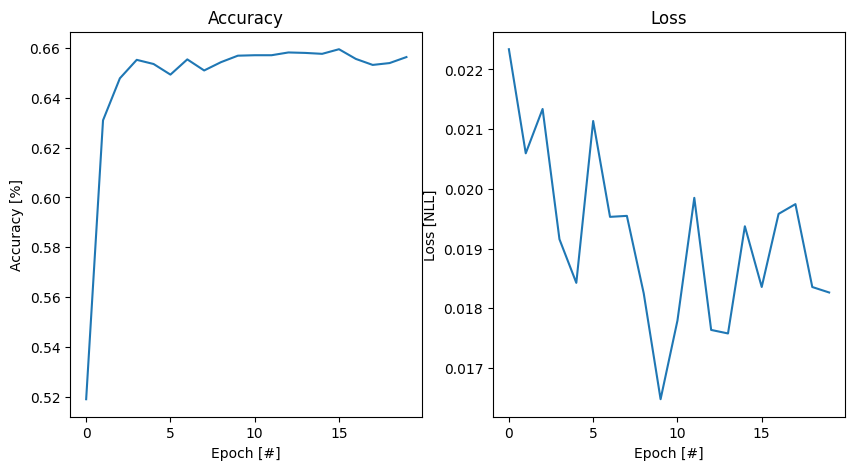

Best accuracy: 0.6594444444444445


In [11]:
effnet_fc = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')

for name, param in effnet_fc.named_parameters():
    param.requires_grad = False

effnet_fc.classifier = nn.Linear(2048, 10)

effnet_fc.to(device)

# Train the last layer
optimizer = optim.Adam(effnet_fc.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
effnet_fc.to(device)

print("Training last effnet layer")

accuracies_effnet_fc, losses_effnet_fc, time_effnet_fc = training_loop(EPOCHS, effnet_fc, trainloader, testloader, optimizer, loss)
print(f"Best accuracy: {max(accuracies_effnet_fc)}")

features.0.0.weight True
features.0.1.weight True
features.0.1.bias True
features.1.0.block.0.0.weight True
features.1.0.block.0.1.weight True
features.1.0.block.0.1.bias True
features.1.0.block.1.fc1.weight True
features.1.0.block.1.fc1.bias True
features.1.0.block.1.fc2.weight True
features.1.0.block.1.fc2.bias True
features.1.0.block.2.0.weight True
features.1.0.block.2.1.weight True
features.1.0.block.2.1.bias True
features.1.1.block.0.0.weight True
features.1.1.block.0.1.weight True
features.1.1.block.0.1.bias True
features.1.1.block.1.fc1.weight True
features.1.1.block.1.fc1.bias True
features.1.1.block.1.fc2.weight True
features.1.1.block.1.fc2.bias True
features.1.1.block.2.0.weight True
features.1.1.block.2.1.weight True
features.1.1.block.2.1.bias True
features.1.2.block.0.0.weight True
features.1.2.block.0.1.weight True
features.1.2.block.0.1.bias True
features.1.2.block.1.fc1.weight True
features.1.2.block.1.fc1.bias True
features.1.2.block.1.fc2.weight True
features.1.2.bl

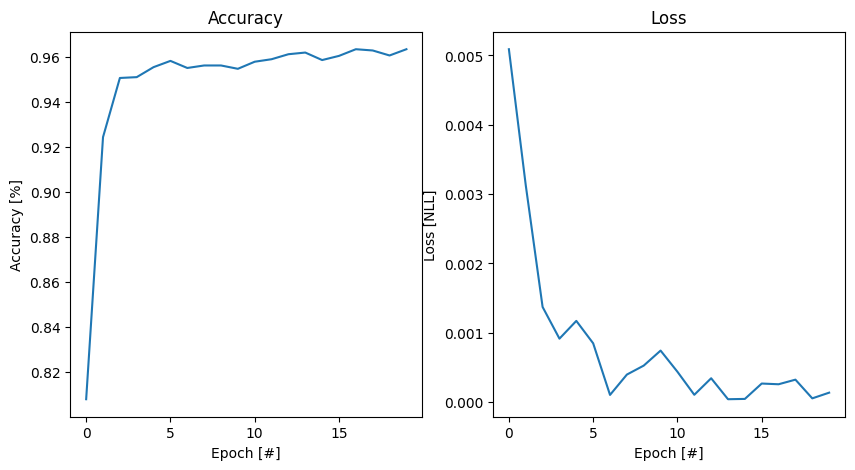

Best accuracy: 0.9635185185185186


In [12]:
effnet_ft = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')
effnet_ft.classifier = nn.Linear(2048, 10)

effnet_ft.to(device)

optimizer = optim.Adam(effnet_ft.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()
effnet_ft.to(device)

print("Fine tune effnet")

accuracies_effnet_ft, losses_effnet_ft, time_effnet_ft = training_loop(EPOCHS, effnet_ft, trainloader, testloader, optimizer, loss)
print(f"Best accuracy: {max(accuracies_effnet_ft)}")


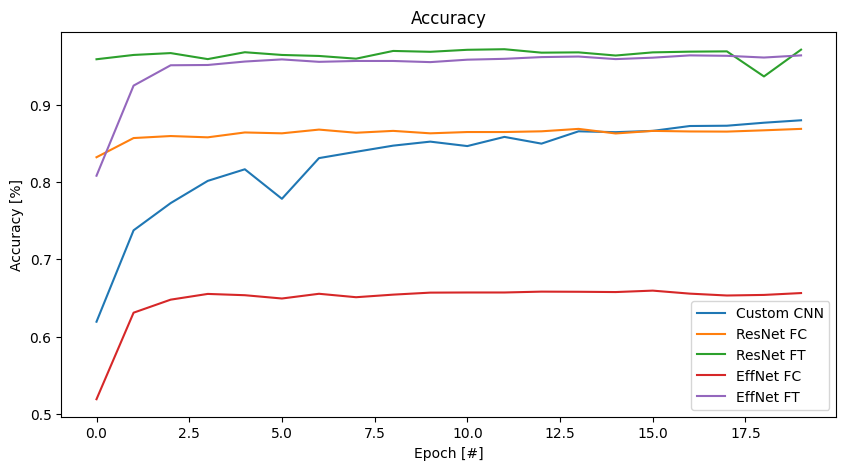

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(accuracies_custom, label='Custom CNN')
plt.plot(accuracies_resnet_fc, label='ResNet FC')
plt.plot(accuracies_resnet_ft, label='ResNet FT')
plt.plot(accuracies_effnet_fc, label='EffNet FC')
plt.plot(accuracies_effnet_ft, label='EffNet FT')
plt.title('Accuracy')
plt.xlabel('Epoch [#]')
plt.ylabel('Accuracy [%]')
plt.legend()
plt.show()

In [16]:
def f_time(time):
    return f"{time // 60}m {round(time % 60)}s"

print(f"Custom CNN: {f_time(time_custom)}")
print(f"ResNet FC: {f_time(time_resnet_fc)}")
print(f"ResNet FT: {f_time(time_resnet_ft)}")
print(f"EffNet FC: {f_time(time_effnet_fc)}")
print(f"EffNet FT: {f_time(time_effnet_ft)}")

Custom CNN: 2.0m 3s
ResNet FC: 2.0m 30s
ResNet FT: 4.0m 6s
EffNet FC: 9.0m 30s
EffNet FT: 26.0m 58s
